In [8]:
import lovely_tensors as lt
from rich import print

from ocpmodels.models.rhescnv8clean.tests.utils import test_context

lt.monkey_patch()

rhctx = test_context("/workspaces/ocp/configs/s2ef/2M/escn/rhescn.yml").__enter__()
escnctx = test_context(
    "/workspaces/ocp/configs/s2ef/2M/escn/eSCN-L6-M2-Lay12.yml"
).__enter__()

2024-04-04 21:04:28 (WARNING): Detected old config, converting to new format. Consider updating to avoid potential incompatibilities.


2024-04-04 21:04:28 (INFO): amp: true
cmd:
  checkpoint_dir: ./checkpoints/2024-04-04-21-05-04
  commit: d273851
  identifier: ''
  logs_dir: ./logs/wandb/2024-04-04-21-05-04
  print_every: 10
  results_dir: ./results/2024-04-04-21-05-04
  seed: 0
  timestamp_id: 2024-04-04-21-05-04
dataset:
  format: trajectory_lmdb
  grad_target_mean: 0.0
  grad_target_std: 2.887317180633545
  key_mapping:
    force: forces
    y: energy
  normalize_labels: true
  src: /mnt/datasets/s2ef/2M/train/
  target_mean: -0.7554450631141663
  target_std: 2.887317180633545
  transforms:
    normalizer:
      energy:
        mean: -0.7554450631141663
        stdev: 2.887317180633545
      forces:
        mean: 0.0
        stdev: 2.887317180633545
eval_metrics:
  metrics:
    energy:
    - mae
    forces:
    - forcesx_mae
    - forcesy_mae
    - forcesz_mae
    - mae
    - cosine_similarity
    - magnitude_error
    misc:
    - energy_forces_within_threshold
gpus: 1
logger: wandb
loss_fns:
- energy:
    coeffic

2024-04-04 21:04:28 (WARNING): Detected old config, converting to new format. Consider updating to avoid potential incompatibilities.


2024-04-04 21:04:28 (INFO): amp: true
cmd:
  checkpoint_dir: ./checkpoints/2024-04-04-21-05-04
  commit: d273851
  identifier: ''
  logs_dir: ./logs/wandb/2024-04-04-21-05-04
  print_every: 10
  results_dir: ./results/2024-04-04-21-05-04
  seed: 0
  timestamp_id: 2024-04-04-21-05-04
dataset:
  format: trajectory_lmdb
  grad_target_mean: 0.0
  grad_target_std: 2.887317180633545
  key_mapping:
    force: forces
    y: energy
  normalize_labels: true
  src: /mnt/datasets/s2ef/2M/train/
  target_mean: -0.7554450631141663
  target_std: 2.887317180633545
  transforms:
    normalizer:
      energy:
        mean: -0.7554450631141663
        stdev: 2.887317180633545
      forces:
        mean: 0.0
        stdev: 2.887317180633545
eval_metrics:
  metrics:
    energy:
    - mae
    forces:
    - forcesx_mae
    - forcesy_mae
    - forcesz_mae
    - mae
    - cosine_similarity
    - magnitude_error
    misc:
    - energy_forces_within_threshold
gpus: 1
logger: wandb
loss_fns:
- energy:
    coeffic

In [9]:
rhescn = rhctx.trainer._unwrapped_model
escn = escnctx.trainer._unwrapped_model
dl = rhctx.trainer.train_loader
batch = next(iter(dl)).cuda()
print(type(rhescn), type(escn), type(dl), batch)

<class 'ocpmodels.models.rhescnv8clean.model.RHESCN'> <class 'ocpmodels.models.escn.escn.eSCN'> <class 
'torch.utils.data.dataloader.DataLoader'> DataBatch(pos=[51, 3], cell=[1, 3, 3], atomic_numbers=[51], natoms=[1], 
tags=[51], fixed=[51], sid=[1], fid=[1], id=[1], energy=[1], forces=[51, 3], batch=[51], ptr=[2])

In [10]:
from ocpmodels.models.rhescnv8clean.radius_graph_utils import (
    generate_graph,
)

(
    edge_index,
    edge_distance,
    edge_distance_vec,
    _,
    _,  # cell offset distances
    _,
) = generate_graph(
    batch.pos,
    batch.cell,
    batch.batch,
    batch.natoms,
    cutoff=rhescn.cutoff,
    max_neighbors=rhescn.max_neighbors,
    use_pbc=rhescn.use_pbc,
    otf_graph=rhescn.otf_graph,
    padded_collater_config=rhctx.trainer._padded_collater_config,
)
pos = batch.pos
atomic_numbers = batch.atomic_numbers.long()
batch_idx = batch.batch
natoms = batch.natoms
fixed = batch.fixed
energy_target = batch.energy
force_target = batch.forces

print(
    {
        "pos": pos,
        "atomic_numbers": atomic_numbers,
        "batch_idx": batch_idx,
        "natoms": natoms,
        "fixed": fixed,
        "energy_target": energy_target,
        "force_target": force_target,
        "edge_index": edge_index,
        "edge_distance": edge_distance,
        "edge_distance_vec": edge_distance_vec,
    }
)

{
    'pos': tensor[51, 3] n=153 x∈[-0.010, 32.595] μ=10.041 σ=9.819 cuda:0,
    'atomic_numbers': tensor[51] i64 x∈[1, 80] μ=40.000 σ=33.058 cuda:0,
    'batch_idx': tensor[51] i64 all_zeros cuda:0,
    'natoms': tensor[1] i64 cuda:0 [51],
    'fixed': tensor[51] x∈[0., 1.000] μ=0.588 σ=0.497 cuda:0,
    'energy_target': tensor[1] f64 cuda:0 [-2.016],
    'force_target': tensor[51, 3] n=153 x∈[-0.286, 0.253] μ=1.461e-10 σ=0.068 cuda:0,
    'edge_index': tensor[2, 1218] i64 n=2436 (19Kb) x∈[0, 50] μ=24.060 σ=14.260 cuda:0,
    'edge_distance': tensor[1218] 4.8Kb x∈[1.092, 8.069] μ=4.571 σ=1.319 cuda:0,
    'edge_distance_vec': tensor[1218, 3] n=3654 (14Kb) x∈[-7.391, 7.197] μ=0.000 σ=2.747 cuda:0
}

In [11]:
from ocpmodels.models.rhescnv8clean.wigner_efficient import rot_from_xyz

wigner_precomp = rot_from_xyz(
    edge_distance_vec,
    rhescn.rh_grid.from_grid_sh_tri,
    rhescn.jdp,
    rhescn.mmax_list[0],
    rhescn.rh_idx,
    rhescn.rh_mask,
    device=edge_distance_vec.device,
    dtype=edge_distance_vec.dtype,
    keep_full_wigner=True,
    keep_rot_mat=True,
    rotmat_seed=0,
    use_rotmat=True,
    # vectorize=False,
)
print(wigner_precomp)

Rhomboidal_SO3_Rotation_Parallel_FastMM(
    wigner=tensor[2436, 50, 81] n=9865800 (38Mb) x∈[-1.000, 1.000] μ=0.000 σ=0.105 cuda:0,
    wigner_inv_from_grid=tensor[1218, 81, 342] n=33741036 (0.1Gb) x∈[-0.062, 0.067] μ=0.000 σ=0.012 cuda:0,
    full_wigner=tensor[1218, 81, 81] n=7991298 (30Mb) x∈[-1.000, 1.000] μ=0.000 σ=0.111 cuda:0,
    rotmat=tensor[1218, 3, 3] n=10962 (43Kb) x∈[-1.000, 1.000] μ=-0.050 σ=0.575 cuda:0
)

tensor[1218, 81, 81] n=7991298 (30Mb) x∈[-1.000, 1.000] μ=0.000 σ=0.111 cuda:0

tensor[81] x∈[-0.868, 1.000] μ=0.005 σ=0.378 cuda:0
tensor([ 1.0000e+00, -7.4986e-01,  8.6562e-01, -8.6756e-01,  4.3548e-01,
        -4.3064e-01,  6.2395e-01, -7.5209e-01,  4.4030e-01, -4.5464e-03,
         2.5028e-01, -4.2120e-02,  3.2310e-01, -5.9810e-01,  2.7245e-01,
        -4.5827e-03, -3.7363e-01, -1.9936e-03,  5.1668e-02,  3.3121e-01,
         2.1476e-02, -4.2505e-01,  1.1101e-01, -2.2285e-03, -3.7365e-01,
         6.0831e-01, -1.2252e-01,  4.5309e-04, -1.3051e-01,  6.1032e-01,
        -2.2502e-01, -2.5366e-01, -1.0828e-02, -3.9600e-04, -1.2267e-01,
         6.0831e-01, -6.5877e-01,  1.1784e-01,  6.7665e-02,  2.6668e-03,
        -2.7071e-01,  7.3965e-01, -3.7499e-01, -1.0267e-01, -7.0867e-02,
         4.1450e-04,  6.7002e-02,  1.1786e-01, -6.5877e-01,  5.3620e-01,
        -3.9101e-02, -2.0452e-01,  1.7776e-01,  4.6929e-03, -3.5195e-01,
         6.9925e-01, -4.0996e-01,  1.3921e-02, -6.2930e-02, -1.7197e-04,
         1.7559e-01, -2.0439e-01, -3.9103e-02,  5.3620e-01, -2.9404e-01,
        -4.0227e-02,  3.1223e-01, -3.4684e-01,  2.0611e-01,  6.7068e-03,
        -3.6829e-01,  5.0841e-01, -3.3726e-01,  8.8565e-02,  2.0738e-03,
        -2.3148e-03,  2.0036e-01, -3.4635e-01,  3.1221e-01, -4.0227e-02,
        -2.9404e-01], device='cuda:0')

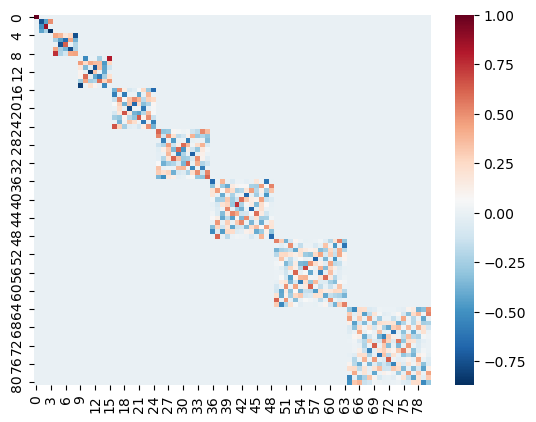

In [24]:
import seaborn as sns
import torch

full_wigner = wigner_precomp.full_wigner
print(full_wigner)

sns.heatmap(full_wigner[1].cpu().numpy(), cmap="RdBu_r")

print(torch.diag(full_wigner[1]).v)